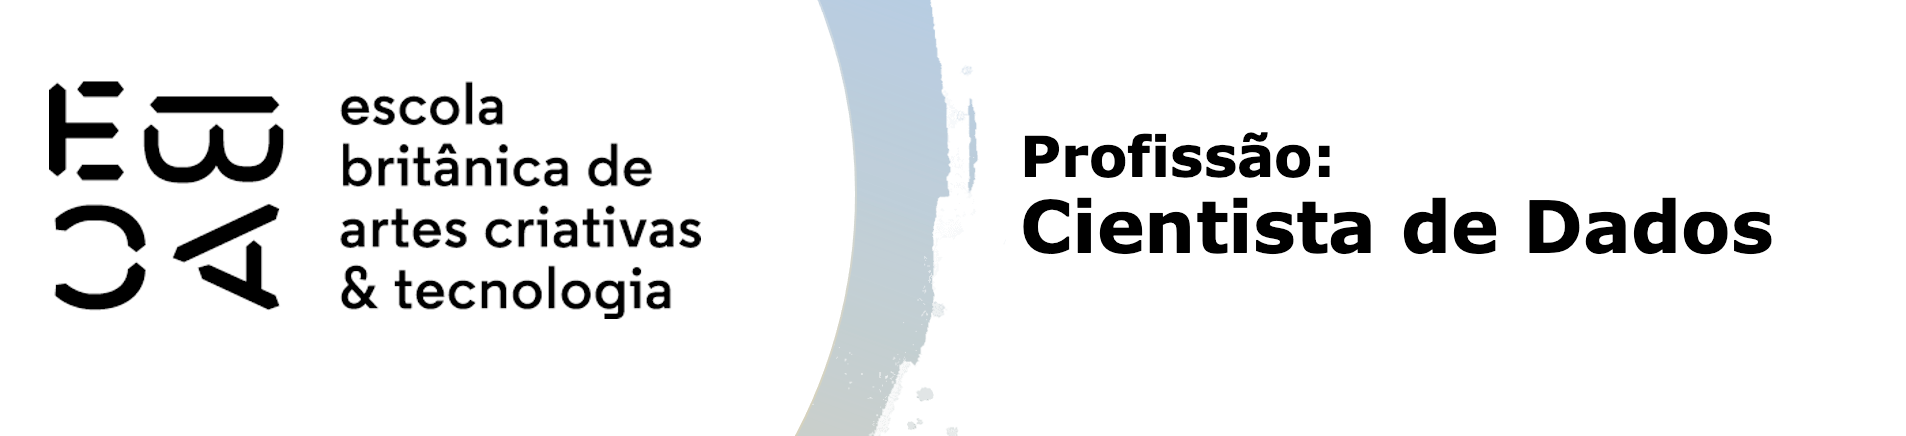

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from pycaret.classification import *

import warnings

from statsmodels.tools.sm_exceptions import PerfectSeparationWarning
warnings.filterwarnings('ignore', category=PerfectSeparationWarning)
warnings.filterwarnings('ignore', message='.*set_ticklabels.*')

In [2]:
df_raw = pd.read_feather(r'.\data\credit_scoring.ftr')
df = df_raw.copy()
df.drop(columns=['index'], inplace=True)
df.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
df['data_ref'].unique()

array(['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [4]:
dfamostra = df[df['data_ref'] < '2016-01-01'].copy()
validacao = df[df['data_ref'] >= '2016-01-01'].copy()

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [5]:
dfamostra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               600000 non-null  datetime64[ns]
 1   sexo                   600000 non-null  object        
 2   posse_de_veiculo       600000 non-null  object        
 3   posse_de_imovel        600000 non-null  object        
 4   qtd_filhos             600000 non-null  int64         
 5   tipo_renda             600000 non-null  object        
 6   educacao               600000 non-null  object        
 7   estado_civil           600000 non-null  object        
 8   tipo_residencia        600000 non-null  object        
 9   idade                  600000 non-null  int64         
 10  tempo_emprego          499125 non-null  float64       
 11  qt_pessoas_residencia  600000 non-null  float64       
 12  renda                  600000 non-null  floa

In [6]:
dfamostra.groupby('mau').size()

mau
False    563357
True      36643
dtype: int64

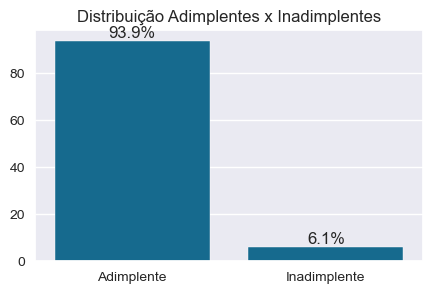

In [7]:
sns.set_style(style='darkgrid')

fig, ax = plt.subplots(figsize=(5, 3))

bars = sns.countplot(data=dfamostra, x='mau', stat='percent', ax=ax)
ax.bar_label(bars.containers[0], fmt='%.1f%%')

ax.set_title('Distribuição Adimplentes x Inadimplentes')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(['Adimplente', 'Inadimplente']);

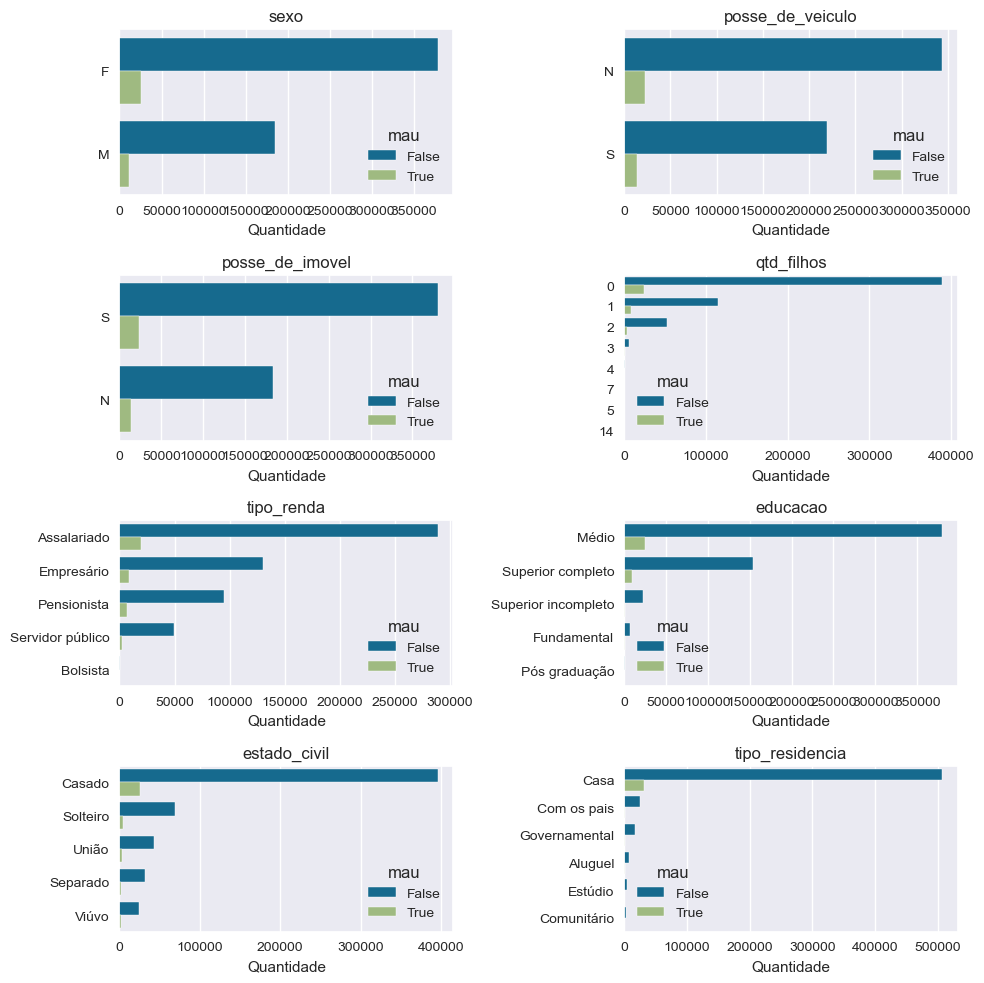

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
               'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

ax = ax.ravel()

for i, cat in enumerate(categoricas):
    order = dfamostra[cat].value_counts().index
    sns.countplot(
        data=dfamostra,
        y=cat,
        hue='mau',
        ax=ax[i],
        order=order)
    
    ax[i].set_title(cat)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('Quantidade')

plt.tight_layout()
plt.show();

In [9]:
def pct_inadimplencia(df, explicativa, ax=None):
    group = df.groupby('mau').size()
    inadimplencia_media = group[1] / group.sum()
    
    cross_tab = pd.crosstab(index=df[explicativa],
                            columns=df['mau'],
                            normalize='index')
    
    if ax is None:
        fig, ax = plt.subplots()
    
    bars = sns.barplot(data=cross_tab,
                       x=cross_tab.index,
                       y=cross_tab[True] * 100,
                       ax=ax)
    
    ax.set_title(f'% de Inadimplência: {explicativa}')
    ax.set_ylabel('% de Inadimplência')
    ax.set_xlabel('')
    ax.bar_label(bars.containers[0], fmt='%.1f%%')
    ax.yaxis.set_major_formatter(PercentFormatter(100))
    
    ax.axhline(inadimplencia_media * 100,
               color='r',
               linestyle='--',
               label='Inadimplência Geral')
    
    ymax = max(cross_tab[True].max() * 100, inadimplencia_media * 100) * 1.2
    ax.set_ylim(0, ymax)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    
    if ax is None:
        plt.show()

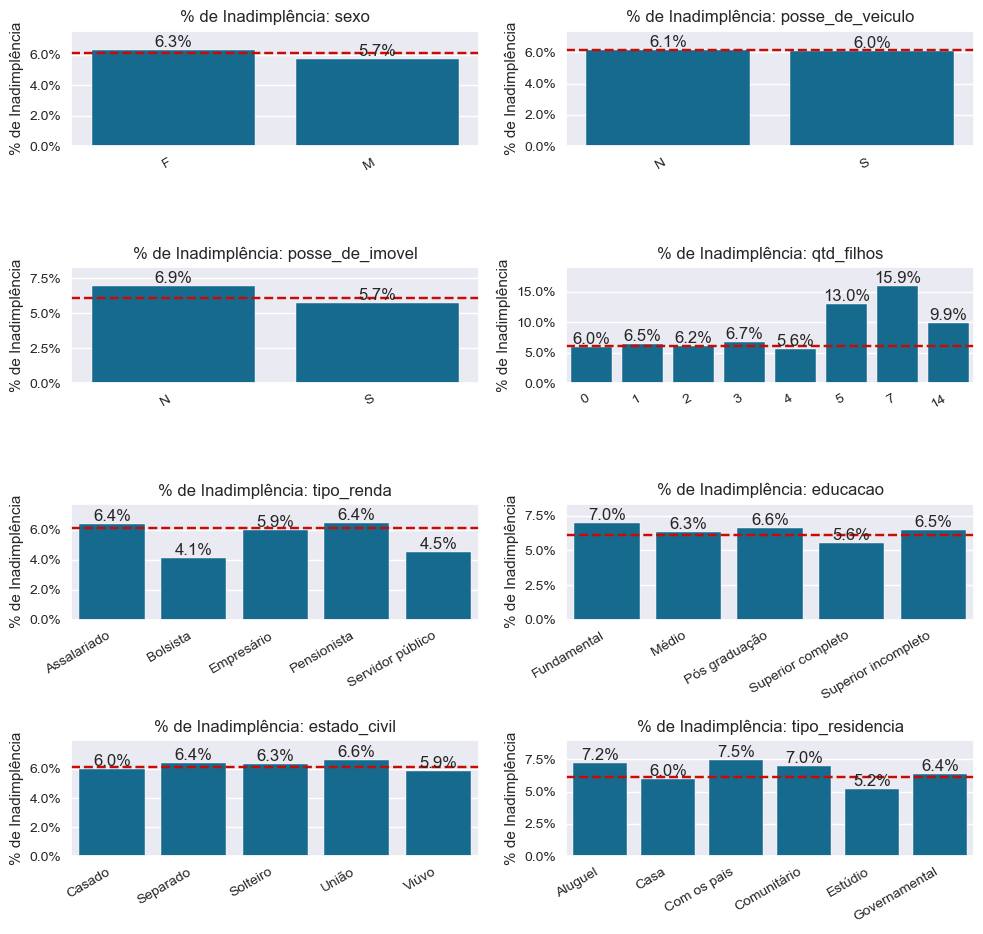

In [10]:
categoricas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
               'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
ax = ax.ravel()

for i, cat in enumerate(categoricas):
    pct_inadimplencia(dfamostra, cat, ax[i])

plt.tight_layout(rect=[0,0.05,1,1])
plt.show();

In [11]:
var = 'tipo_residencia'

pd.DataFrame({
    'Quantidade': dfamostra[var].value_counts(),
    'Share': dfamostra[var].value_counts(normalize=True),
    'Aculmulado': dfamostra[var].value_counts(normalize=True).cumsum()
})

,Quantidade,Share,Aculmulado
Casa,539336,0.898893,0.898893
Com os pais,26730,0.044550,0.943443
Governamental,18742,0.031237,0.974680
Aluguel,8262,0.013770,0.988450
Estúdio,4296,0.007160,0.995610
Comunitário,2634,0.004390,1.000000


In [12]:
df_tipo_res = dfamostra[['tipo_residencia', 'mau']]

df_tipo_res.loc[df_tipo_res['tipo_residencia'] == 'Casa', 'cat_res'] = 'res_estavel'
df_tipo_res.loc[df_tipo_res['tipo_residencia'] == 'Com os pais', 'cat_res'] = 'res_instavel'
df_tipo_res.loc[df_tipo_res['tipo_residencia'] == 'Governamental', 'cat_res'] = 'res_instavel'
df_tipo_res.loc[df_tipo_res['tipo_residencia'] == 'Aluguel', 'cat_res'] = 'res_instavel'
df_tipo_res.loc[df_tipo_res['tipo_residencia'] == 'Estúdio', 'cat_res'] = 'res_estavel'
df_tipo_res.loc[df_tipo_res['tipo_residencia'] == 'Comunitário', 'cat_res'] = 'res_instavel'

estavel = df_tipo_res[df_tipo_res['cat_res'] == 'res_estavel']['mau']
instavel = df_tipo_res[df_tipo_res['cat_res'] == 'res_instavel']['mau']

t_stat, p_val = stats.ttest_ind(estavel, instavel, equal_var=False)

print('t-statistic:', t_stat)
print('p-value:', p_val)

t-statistic: -9.16545783178387
p-value: 5.0686984701676294e-20


In [13]:
estavel.mean()

0.06010315801865968

In [14]:
instavel.mean()

0.07041229066136816

In [15]:
dfamostra.fillna({'tempo_emprego': dfamostra['tempo_emprego'].mean()}, inplace=True)

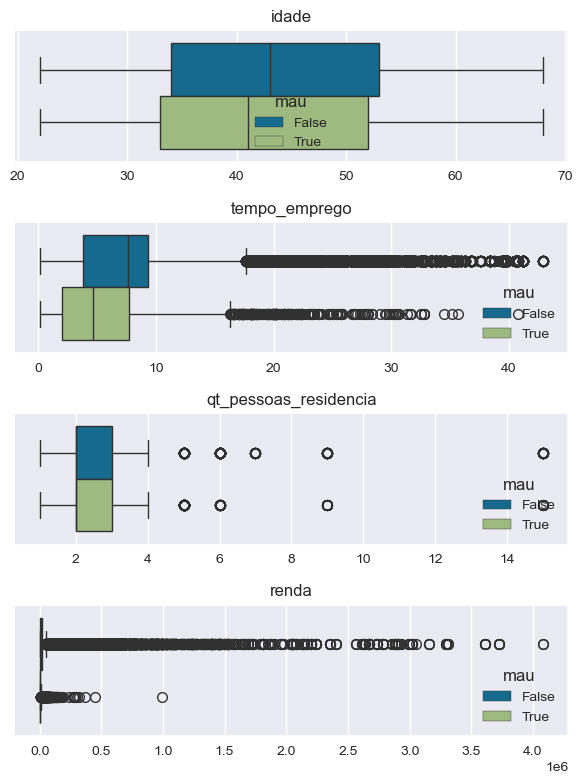

In [16]:
fig, ax = plt.subplots(nrows=4, figsize=(6,8))
ax = ax.ravel()

numericas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

for i, num in enumerate(numericas):
    sns.boxplot(
        data=dfamostra,
        x=num,
        hue='mau',
        ax=ax[i])
    
    ax[i].set_title(num)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show();

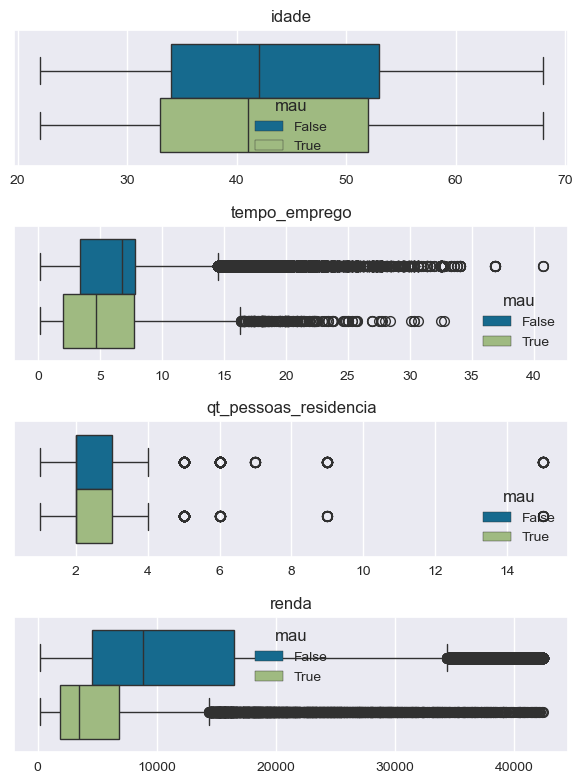

In [17]:
fig, ax = plt.subplots(nrows=4, figsize=(6,8))
ax = ax.ravel()

q95_renda = df['renda'].quantile(0.9)

numericas = ['idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

for i, num in enumerate(numericas):
    sns.boxplot(
        data=dfamostra[dfamostra['renda'] < q95_renda],
        x=num,
        hue='mau',
        ax=ax[i])
    
    ax[i].set_title(num)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show();

_______

In [18]:
print(f"Idade mínima: {dfamostra['idade'].min()}")
print(f"Idade máxima: {dfamostra['idade'].max()}")

Idade mínima: 22
Idade máxima: 68


In [19]:
df_idade = dfamostra[['idade', 'mau']]

df_idade.loc[(df_idade['idade'] >= 0) & (df_idade['idade'] < 30), 'cat_idade'] = '0-29'
df_idade.loc[(df_idade['idade'] >= 30) & (df_idade['idade'] < 40), 'cat_idade'] = '30-39'
df_idade.loc[(df_idade['idade'] >= 40) & (df_idade['idade'] < 50), 'cat_idade'] = '40-49'
df_idade.loc[(df_idade['idade'] >= 50) & (df_idade['idade'] < 60), 'cat_idade'] = '50-59'
df_idade.loc[df_idade['idade'] >= 60, 'cat_idade'] = '60+'


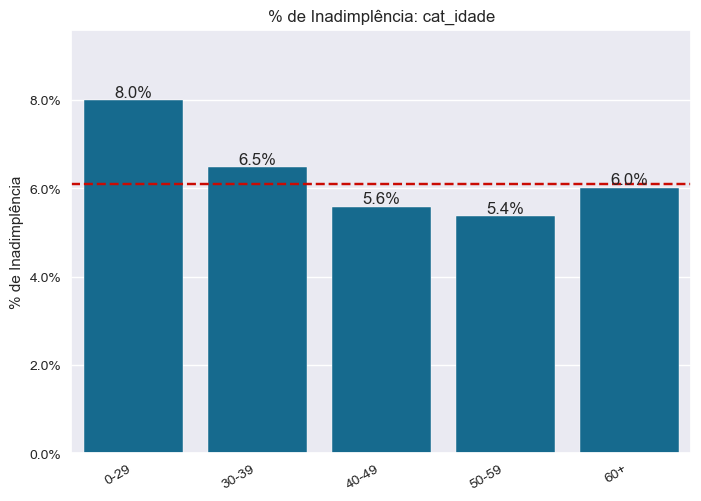

In [20]:
pct_inadimplencia(df_idade, 'cat_idade')

In [21]:
var = 'cat_idade'

pd.DataFrame({
    'Quantidade': df_idade[var].value_counts(),
    'Share': df_idade[var].value_counts(normalize=True),
    'Aculmulado': df_idade[var].value_counts(normalize=True).cumsum()
})

,Quantidade,Share,Aculmulado
30-39,172191,0.286985,0.286985
40-49,161856,0.269760,0.556745
50-59,133496,0.222493,0.779238
0-29,66984,0.111640,0.890878
60+,65473,0.109122,1.000000


_______

In [22]:
print(f"Tempo emprego mínimo: {dfamostra['tempo_emprego'].min()}")
print(f"Tempo emprego máximo: {dfamostra['tempo_emprego'].max()}")

Tempo emprego mínimo: 0.1178082191780822
Tempo emprego máximo: 42.90684931506849


In [23]:
df_te = dfamostra[['tempo_emprego', 'mau']]

df_te.loc[(df_te['tempo_emprego'] >= 0) & (df_te['tempo_emprego'] < 3), 'cat_te'] = '00-02'
df_te.loc[(df_te['tempo_emprego'] >= 3) & (df_te['tempo_emprego'] < 7), 'cat_te'] = '03-06'
df_te.loc[(df_te['tempo_emprego'] >= 7) & (df_te['tempo_emprego'] < 15), 'cat_te'] = '07-14'
df_te.loc[(df_te['tempo_emprego'] >= 15) & (df_te['tempo_emprego'] < 25), 'cat_te'] = '15-24'
df_te.loc[df_te['tempo_emprego'] >= 25, 'cat_te'] = '25+'

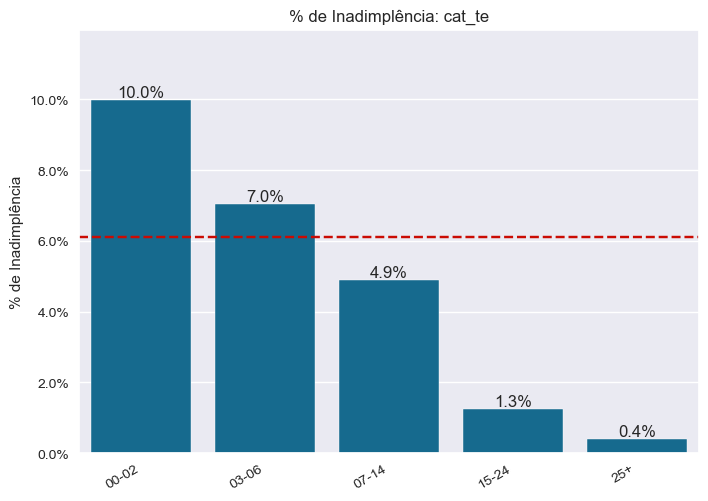

In [24]:
pct_inadimplencia(df_te, 'cat_te')

In [25]:
var = 'cat_te'

pd.DataFrame({
    'Quantidade': df_te[var].value_counts(),
    'Share': df_te[var].value_counts(normalize=True),
    'Aculmulado': df_te[var].value_counts(normalize=True).cumsum()
})

,Quantidade,Share,Aculmulado
07-14,251475,0.419125,0.419125
03-06,163043,0.271738,0.690863
00-02,122390,0.203983,0.894847
15-24,47398,0.078997,0.973843
25+,15694,0.026157,1.000000


_______

In [26]:
print(f"Quantidade mínima de pessoas na residência: {dfamostra['qt_pessoas_residencia'].min()}")
print(f"IQuantidade máxima de pessoas na residência: {dfamostra['qt_pessoas_residencia'].max()}")

Quantidade mínima de pessoas na residência: 1.0
IQuantidade máxima de pessoas na residência: 15.0


In [27]:
df_qpr = dfamostra[['qt_pessoas_residencia', 'mau']]

df_qpr.loc[(df_qpr['qt_pessoas_residencia'] >= 0) & (df_qpr['qt_pessoas_residencia'] < 3), 'cat_qpr'] = '00-02'
df_qpr.loc[(df_qpr['qt_pessoas_residencia'] >= 3) & (df_qpr['qt_pessoas_residencia'] < 5), 'cat_qpr'] = '03-05'
df_qpr.loc[df_qpr['qt_pessoas_residencia'] >= 5, 'cat_qpr'] = '05+'

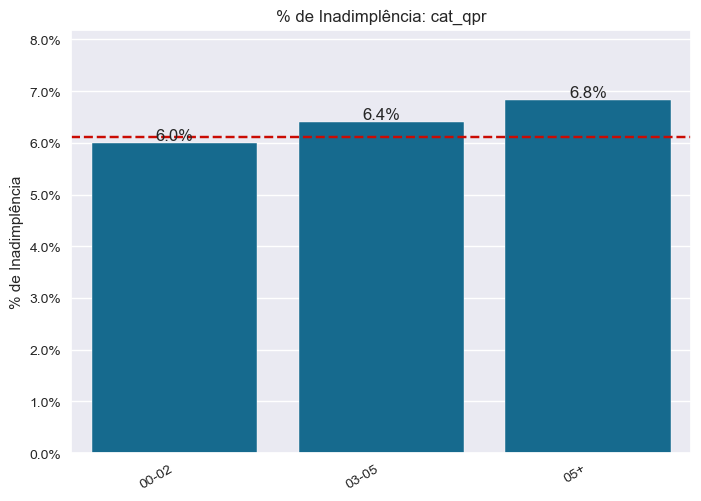

In [28]:
pct_inadimplencia(df_qpr, 'cat_qpr')

In [29]:
var = 'cat_qpr'

pd.DataFrame({
    'Quantidade': df_qpr[var].value_counts(),
    'Share': df_qpr[var].value_counts(normalize=True),
    'Aculmulado': df_qpr[var].value_counts(normalize=True).cumsum()
})

,Quantidade,Share,Aculmulado
00-02,434838,0.72473,0.72473
03-05,157440,0.26240,0.98713
05+,7722,0.01287,1.00000


_______

In [30]:
print(f"Renda mínima: {dfamostra['renda'].min()}")
print(f"Renda máxima: {dfamostra['renda'].max()}")

Renda mínima: 161.86
Renda máxima: 4083986.22


In [31]:
df_renda = dfamostra[['renda', 'mau']]

df_renda.loc[(df_renda['renda'] >= 0) & (df_renda['renda'] < 5000), 'cat_renda'] = '000k-005k'
df_renda.loc[(df_renda['renda'] >= 5000) & (df_renda['renda'] < 15000), 'cat_renda'] = '005k-015k'
df_renda.loc[(df_renda['renda'] >= 15000) & (df_renda['renda'] < 50000), 'cat_renda'] = '015k-050k'
df_renda.loc[(df_renda['renda'] >= 50000) & (df_renda['renda'] < 500000), 'cat_renda'] = '050k-500k'
df_renda.loc[df_renda['renda'] >= 500000, 'cat_renda'] = '500k+'

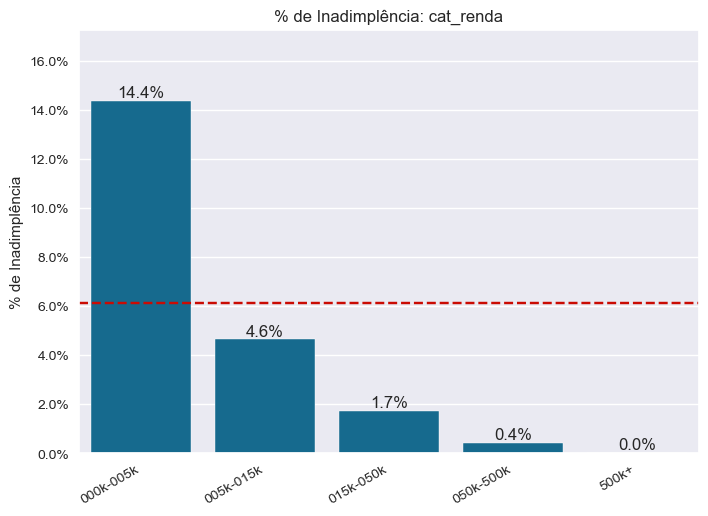

In [32]:
pct_inadimplencia(df_renda, 'cat_renda')

In [33]:
var = 'cat_renda'

pd.DataFrame({
    'Quantidade': df_renda[var].value_counts(),
    'Share': df_renda[var].value_counts(normalize=True),
    'Aculmulado': df_renda[var].value_counts(normalize=True).cumsum()
})

,Quantidade,Share,Aculmulado
005k-015k,223697,0.372828,0.372828
000k-005k,162137,0.270228,0.643057
015k-050k,155521,0.259202,0.902258
050k-500k,55656,0.092760,0.995018
500k+,2989,0.004982,1.000000


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

Bem, já fiz no item anterior 😅

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [34]:
dfamostra['log_renda'] = np.log(dfamostra['renda'] + 0.01)

dfamostra.loc[dfamostra['tipo_residencia'] == 'Casa', 'cat_residencia'] = 'res_estavel'
dfamostra.loc[dfamostra['tipo_residencia'] == 'Com os pais', 'cat_residencia'] = 'res_instavel'
dfamostra.loc[dfamostra['tipo_residencia'] == 'Governamental', 'cat_residencia'] = 'res_instavel'
dfamostra.loc[dfamostra['tipo_residencia'] == 'Aluguel', 'cat_residencia'] = 'res_instavel'
dfamostra.loc[dfamostra['tipo_residencia'] == 'Estúdio', 'cat_residencia'] = 'res_estavel'
dfamostra.loc[dfamostra['tipo_residencia'] == 'Comunitário', 'cat_residencia'] = 'res_instavel'

In [35]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [36]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [37]:
dfamostra.columns

Index(['data_ref', 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau', 'log_renda',
       'cat_residencia'],
      dtype='object')

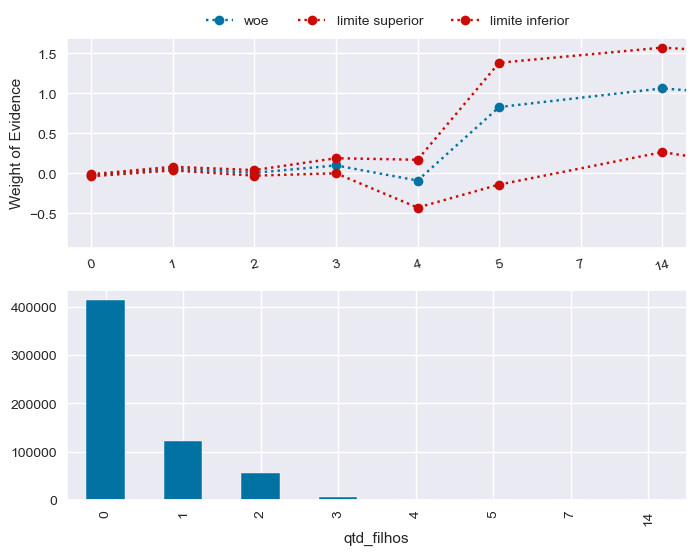

In [38]:
biv_discreta('qtd_filhos', dfamostra);

In [39]:
iv_sexo = IV(dfamostra.cat_residencia, dfamostra.mau)
print(f'IV da variável SEXO: {iv_sexo:.1%}')

IV da variável SEXO: 0.3%


In [40]:
metadados = pd.DataFrame(dfamostra.dtypes, columns=['dtype'])
metadados['nmissing'] = dfamostra.isna().sum()
metadados['valores_unicos'] = dfamostra.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,12,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


In [41]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(dfamostra[var],5,duplicates='drop'), dfamostra.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(dfamostra[var], dfamostra.mau)

    
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
bom,int32,0,2,covariavel,inf
renda,float64,0,112472,covariavel,0.959826
log_renda,float64,0,112472,covariavel,0.959826
tempo_emprego,float64,0,3005,covariavel,0.283956
data_ref,datetime64[ns],0,12,covariavel,0.247065
idade,int64,0,47,covariavel,0.018434
tipo_renda,object,0,5,covariavel,0.009718
posse_de_imovel,object,0,2,covariavel,0.009690
educacao,object,0,5,covariavel,0.003690
tipo_residencia,object,0,6,covariavel,0.003330


In [42]:
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'bom + renda + log_renda + tempo_emprego + data_ref + idade + tipo_renda + posse_de_imovel + educacao + tipo_residencia + sexo + cat_residencia + estado_civil + qt_pessoas_residencia + posse_de_veiculo + qtd_filhos + mau'

In [43]:
%%time
formula = '''
    mau ~ renda + log_renda + tempo_emprego + idade +
    tipo_renda + posse_de_imovel + educacao + tipo_residencia +
    sexo + cat_residencia + estado_civil + qt_pessoas_residencia
    + posse_de_veiculo + qtd_filhos
'''

rl = smf.glm(formula, data=dfamostra, family=sm.families.Binomial()).fit()
rl.summary()

CPU times: total: 2min 49s
Wall time: 1min 34s


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599973
Model Family:                         Binomial   Df Model:                           26
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2026e+05
Date:                         Sun, 28 Sep 2025   Deviance:                   2.4053e+05
Time:                                 16:33:56   Pearson chi2:                 6.00e+05
No. Iterations:                            100   Pseudo R-squ. (CS):            0.05723
Covariance Type:                     nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -4.5455      0.148    -30.622      0.000      -4.836      -4.255
tipo_renda[T.Bolsista]              -0.2143      0.300     -0.715      0.475      -0.802       0.373
tipo_renda[T.Empresário]             0.0048      0.014      0.335      0.737      -0.023       0.033
tipo_renda[T.Pensionista]            0.0006      0.021      0.027      0.978      -0.040       0.041
tipo_renda[T.Servidor público]      -0.0053      0.024     -0.224      0.823      -0.052       0.041
posse_de_imovel[T.S]                 0.0173      0.012      1.432      0.152      -0.006       0.041
educacao[T.Médio]                   -0.0057      0.050     -0.114      0.909      -0.104       0.092
educacao[T.Pós graduação]           -0.0678      0.171     -0.396      0.692      -0.403       0.268
educacao[T.Superior completo]       -0.0018      0.051     -0.035      0.972      -0.102       0.098
educacao[T.Superior incompleto]     -0.0193      0.057     -0.338      0.736      -0.131       0.093
tipo_residencia[T.Casa]             -1.4929      0.054    -27.870      0.000      -1.598      -1.388
tipo_residencia[T.Com os pais]      -0.0161      0.051     -0.316      0.752      -0.116       0.084
tipo_residencia[T.Comunitário]       0.0983      0.092      1.069      0.285      -0.082       0.279
tipo_residencia[T.Estúdio]          -1.5433      0.074    -20.872      0.000      -1.688      -1.398
tipo_residencia[T.Governamental]     0.0056      0.055      0.101      0.919      -0.102       0.113
sexo[T.M]                            0.0082      0.013      0.611      0.541      -0.018       0.035
cat_residencia[T.res_instavel]      -1.5093      0.062    -24.480      0.000      -1.630      -1.388
estado_civil[T.Separado]             0.1014      0.092      1.102      0.270      -0.079       0.282
estado_civil[T.Solteiro]             0.0959      0.090      1.066      0.286      -0.080       0.272
estado_civil[T.União]               -0.0568      0.021     -2.733      0.006      -0.097      -0.016
estado_civil[T.Viúvo]                0.1095      0.094      1.169      0.242      -0.074       0.293
posse_de_veiculo[T.S]               -0.0300      0.013     -2.375      0.018      -0.055      -0.005
renda                              3.38e-07   6.23e-07      0.543      0.587   -8.82e-07    1.56e-06
log_renda                            0.9856      0.008    123.315      0.000       0.970       1.001
tempo_emprego                        0.0016      0.002      0.879      0.379      -0.002       0.005
idade                               -0.0012      0.001     -1.745      0.081      -0.003       0.000
qt_pessoas_residencia                0.1063      0.089 

In [44]:
var_drop =[
    'mau', 'qtd_filhos', 'tipo_residencia', 'renda', 'data_ref', 'educacao',
    'posse_de_veiculo', 'tipo_renda', 'qt_pessoas_residencia', 'estado_civil'] 

metadados.drop(index=var_drop).sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
bom,int32,0,2,covariavel,inf
log_renda,float64,0,112472,covariavel,0.959826
tempo_emprego,float64,0,3005,covariavel,0.283956
idade,int64,0,47,covariavel,0.018434
posse_de_imovel,object,0,2,covariavel,0.009690
sexo,object,0,2,covariavel,0.002665
cat_residencia,object,0,2,covariavel,0.002591


In [45]:
%%time
formula = '''
    mau ~ log_renda + tempo_emprego + idade +
    posse_de_imovel + sexo + cat_residencia
'''

rl = smf.glm(formula, data=dfamostra, family=sm.families.Binomial()).fit()
rl.summary()

CPU times: total: 7.8 s
Wall time: 7.46 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               600000
Model:                                     GLM   Df Residuals:                   599993
Model Family:                         Binomial   Df Model:                            6
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.2027e+05
Date:                         Sun, 28 Sep 2025   Deviance:                   2.4055e+05
Time:                                 16:34:07   Pearson chi2:                 5.98e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.05720
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -5.8811      0.056   -105.632      0.000      -5.990      -5.772
posse_de_imovel[T.S]               0.0182      0.012      1.510      0.131      -0.005       0.042
sexo[T.M]                         -0.0019      0.012     -0.152      0.879      -0.026       0.023
cat_residencia[T.res_instavel]    -0.0161      0.019     -0.863      0.388      -0.053       0.021
log_renda                          0.9880      0.007    150.366      0.000       0.975       1.001
tempo_emprego                      0.0016      0.002      0.957      0.339      -0.002       0.005
idade                             -0.0009      0.001     -1.656      0.098      -0.002       0.000
==================================================================================================
"""

In [46]:
dfamostra.posse_de_veiculo.unique()

array(['N', 'S'], dtype=object)

In [47]:
t_stat, p_val = stats.ttest_ind(dfamostra[dfamostra['posse_de_veiculo'] == 'N']['mau'],
                                dfamostra[dfamostra['posse_de_veiculo'] == 'S']['mau'],
                                equal_var=False)

print('t-statistic:', t_stat)
print('p-value:', p_val)

t-statistic: 1.6044764285354658
p-value: 0.10860970692664382


In [48]:
dfamostra['score'] = rl.predict(dfamostra)

# Acurácia
acc = metrics.accuracy_score(dfamostra.mau, dfamostra.score>.95)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(dfamostra.mau, dfamostra.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(dfamostra.loc[dfamostra.mau == 1, 'score'], dfamostra.loc[dfamostra.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 37.9% 
AUC: 23.0% 
GINI: -54.0%
KS: 39.9%


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [49]:
validacao.dropna(inplace=True)
validacao['log_renda'] = np.log(validacao['renda'] + 0.01)

validacao.loc[validacao['tipo_residencia'] == 'Casa', 'cat_residencia'] = 'res_estavel'
validacao.loc[validacao['tipo_residencia'] == 'Com os pais', 'cat_residencia'] = 'res_instavel'
validacao.loc[validacao['tipo_residencia'] == 'Governamental', 'cat_residencia'] = 'res_instavel'
validacao.loc[validacao['tipo_residencia'] == 'Aluguel', 'cat_residencia'] = 'res_instavel'
validacao.loc[validacao['tipo_residencia'] == 'Estúdio', 'cat_residencia'] = 'res_estavel'
validacao.loc[validacao['tipo_residencia'] == 'Comunitário', 'cat_residencia'] = 'res_instavel'

validacao['score'] = rl.predict(validacao)

# Acurácia
acc = metrics.accuracy_score(validacao.mau, validacao.score>.5)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(validacao.mau, validacao.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(validacao.loc[validacao.mau == 1, 'score'], validacao.loc[validacao.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 14.3% 
AUC: 25.1% 
GINI: -49.8%
KS: 36.4%


## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [50]:
def fill_na(df):
    metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
    metadados['nan'] = df.isna().sum()
    
    metadados = metadados[metadados['nan'] > 1]
    
    fill_values = {}
    
    for col, row in metadados.iterrows():
        if row['dtype'] in ['int64', 'float64']:
            fill_values[col] = df[col].mode().iloc[0]
        elif row['dtype'] == 'object':
            fill_values[col] = df[col].mode().iloc[0]
        
    return fill_values

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [51]:
def remove_outliers(df):
    df_out = df.copy()
    numeric_cols = df_out.select_dtypes(include=['int64', 'float64']).columns
    
    for col in numeric_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        Q = Q3 - Q1
        lower = Q1 - 2.5 * Q
        upper = Q3 + 2.5 * Q
        
        df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
    
    return df_out

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [52]:
def selecao_variaveis_IV(df, var_resposta, threshold=0.001):
    ivs = {}
    
    for col in df.columns:
        if col != var_resposta:
            ivs[col] = IV(df[col], df[var_resposta])
    
    ranking = pd.DataFrame.from_dict(ivs, orient='index', columns=['IV'])
    ranking = ranking.sort_values(by='IV', ascending=False)
    
    return ranking[ranking['IV'] >= threshold]

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [53]:
def aplicar_pca(df, n_componentes=4):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    x = df[numeric_cols]
    
    x_scaled = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=n_componentes)
    x_pca = pca.fit_transform(x_scaled)
    
    df_pca = pd.DataFrame(x_pca, columns=[f'PC{i+1}' for i in range(n_componentes)])
    
    return df_pca

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [54]:
def criar_dummies(df):
    df_dummies = pd.get_dummies(df, drop_first=True)
    return df_dummies

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [55]:
def aplicar_fill_na(df):
    fill_values = fill_na(df)
    return df.fillna(fill_values)

In [56]:
def aplicar_outliers(df):
    return remove_outliers(df)

In [57]:
def aplicar_selecao(df):
    var_resposta = 'mau'
    ranking = selecao_variaveis_IV(df, var_resposta)
    return df[ranking.index.tolist() + [var_resposta]]

In [58]:
pipeline = Pipeline([
    ('fill_na', FunctionTransformer(aplicar_fill_na)),
    ('remove_outliers', FunctionTransformer(aplicar_outliers)),
    ('selecionar_variaveis', FunctionTransformer(aplicar_selecao)),
    ('criar_dummies', FunctionTransformer(criar_dummies)),
    ('aplicar_pca', FunctionTransformer(aplicar_pca))
])

In [59]:
dfamostra = df[df['data_ref'] < '2016-01-01'].copy()
validacao = df[df['data_ref'] >= '2016-01-01'].copy()

df_final = pipeline.fit_transform(dfamostra)
df_final.head()

,PC1,PC2,PC3,PC4
0,-0.584708,-0.861868,-0.886923,-0.921863
1,-0.843714,0.417669,-0.593174,-0.373555
2,-1.443118,2.255831,0.764713,0.485404
3,1.224144,-0.819478,0.460268,-1.123032
4,-0.323970,-0.117839,-1.634717,-1.171627


### Treinar um modelo de regressão logistica com o resultado

In [60]:
%%time
df_final['mau'] = df['mau']

formula = '''
    mau ~ PC1 + PC2 + PC3 + PC4
'''

rl_b = smf.glm(formula, data=df_final, family=sm.families.Binomial()).fit()
rl_b.summary()

CPU times: total: 2.48 s
Wall time: 1.66 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               545286
Model:                                     GLM   Df Residuals:                   545281
Model Family:                         Binomial   Df Model:                            4
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.1926e+05
Date:                         Sun, 28 Sep 2025   Deviance:                   2.3852e+05
Time:                                 16:34:24   Pearson chi2:                 5.49e+05
No. Iterations:                              6   Pseudo R-squ. (CS):           0.003673
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8271      0.006    470.120      0.000       2.815       2.839
PC1            0.1099      0.005     20.552      0.000       0.099       0.120
PC2           -0.0099      0.005     -1.977      0.048      -0.020   -8.58e-05
PC3           -0.0505      0.007     -6.945      0.000      -0.065      -0.036
PC4            0.3426      0.009     40.203      0.000       0.326       0.359
==============================================================================
"""

### Salvar o pickle file do modelo treinado

In [61]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(rl_b, open(nome_arquivo, 'wb'))

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [62]:
df = df_raw.copy()
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [63]:
df.data_ref.unique()

array(['2015-01-01T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-03-01T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-05-01T00:00:00.000000000', '2015-06-01T00:00:00.000000000',
       '2015-07-01T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [64]:
df.loc[df['tipo_residencia'] == 'Casa', 'cat_residencia'] = 'res_estavel'
df.loc[df['tipo_residencia'] == 'Com os pais', 'cat_residencia'] = 'res_instavel'
df.loc[df['tipo_residencia'] == 'Governamental', 'cat_residencia'] = 'res_instavel'
df.loc[df['tipo_residencia'] == 'Aluguel', 'cat_residencia'] = 'res_instavel'
df.loc[df['tipo_residencia'] == 'Estúdio', 'cat_residencia'] = 'res_estavel'
df.loc[df['tipo_residencia'] == 'Comunitário', 'cat_residencia'] = 'res_instavel'

df.drop(columns='tipo_residencia', inplace=True)

In [65]:
df = df[df['renda'] < df['renda'].quantile(0.9)]

In [66]:
validacao = df[df['data_ref'] >= '2016-01-01'].copy()
print(validacao.shape)

(145878, 15)


In [67]:
treino_mau = df[df['mau'] == True].copy()
treino_bom = df[df['mau'] == False].sample(n=len(treino_mau), random_state=123)

treino = pd.concat([treino_mau, treino_bom])
treino = treino[treino['data_ref'] < '2016-01-01'].copy()

In [68]:
validacao.drop(columns=['data_ref', 'index'], inplace=True)
treino.drop(columns=['data_ref', 'index'], inplace=True)

In [69]:
treino.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'idade', 'tempo_emprego',
       'qt_pessoas_residencia', 'renda', 'mau', 'cat_residencia'],
      dtype='object')

In [70]:
metadados_dict = {
    'sexo': 'categorical',
    'posse_de_veiculo': 'categorical',
    'posse_de_imovel': 'categorical',
    'qtd_filhos': 'numeric',
    'tipo_renda': 'categorical',
    'educacao': 'categorical',
    'estado_civil': 'categorical',
    'cat_residencia': 'categorical',
    'idade': 'numeric',
    'tempo_emprego': 'numeric',
    'qt_pessoas_residencia': 'numeric',
    'renda': 'numeric',
    'mau': 'resposta'}

metadados = pd.DataFrame(
    list(metadados_dict.items()),
    columns=['variavel', 'tipo']).set_index('variavel')

numeric_features = [k for k, v in metadados_dict.items() if v == 'numeric']
categorical_features = [k for k, v in metadados_dict.items() if v == 'categorical']

In [71]:
lgbm_model = setup(data=treino,
                   target='mau',
                   session_id=123,
                   numeric_features=numeric_features,
                   categorical_features=categorical_features,
                   preprocess=True,
                   remove_multicollinearity=True,
                   remove_outliers=True)
                   #pca=True)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(82767, 13)"
4,Transformed data shape,"(79871, 25)"
5,Transformed train set shape,"(55040, 25)"
6,Transformed test set shape,"(24831, 25)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,18.2%


In [72]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6790,0.7383,0.5675,0.6546,0.6079,0.3385,0.3410
1,0.6855,0.7473,0.5724,0.6639,0.6148,0.3516,0.3543
2,0.6835,0.7361,0.5791,0.6579,0.6160,0.3486,0.3507
3,0.6843,0.7461,0.5791,0.6593,0.6166,0.3502,0.3524
4,0.6824,0.7409,0.5720,0.6587,0.6123,0.3456,0.3481
5,0.6890,0.7425,0.5776,0.6680,0.6195,0.3589,0.3616
6,0.6951,0.7505,0.5945,0.6723,0.6310,0.3730,0.3750
7,0.6712,0.7277,0.5579,0.6444,0.5980,0.3222,0.3246
8,0.6803,0.7437,0.5720,0.6551,0.6108,0.3416,0.3439


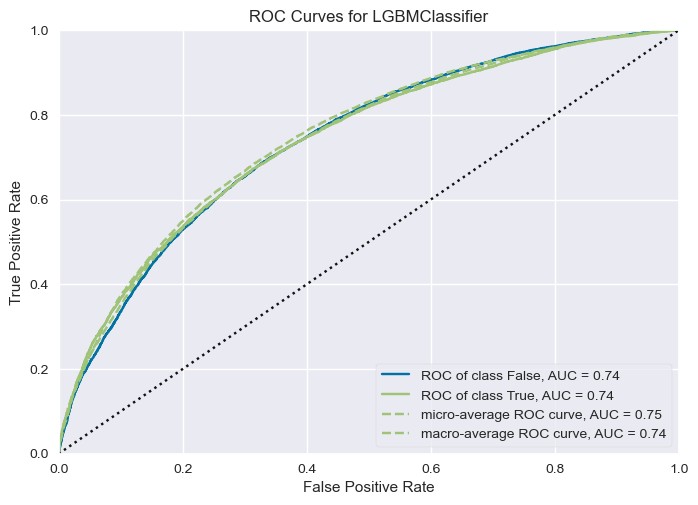

In [73]:
plot_model(lightgbm, plot = 'auc')

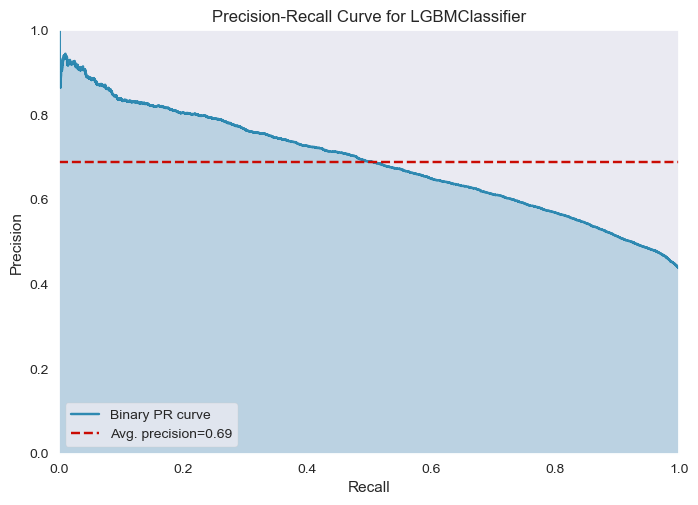

In [74]:
plot_model(lightgbm, plot = 'pr')

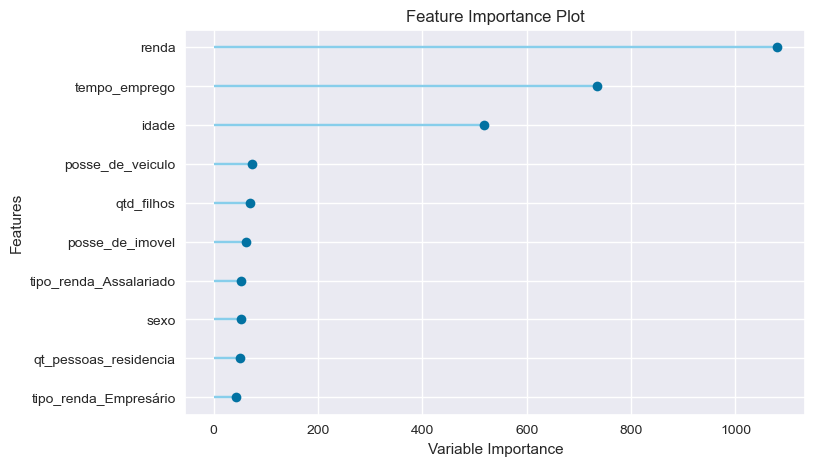

In [75]:
plot_model(lightgbm, plot='feature')

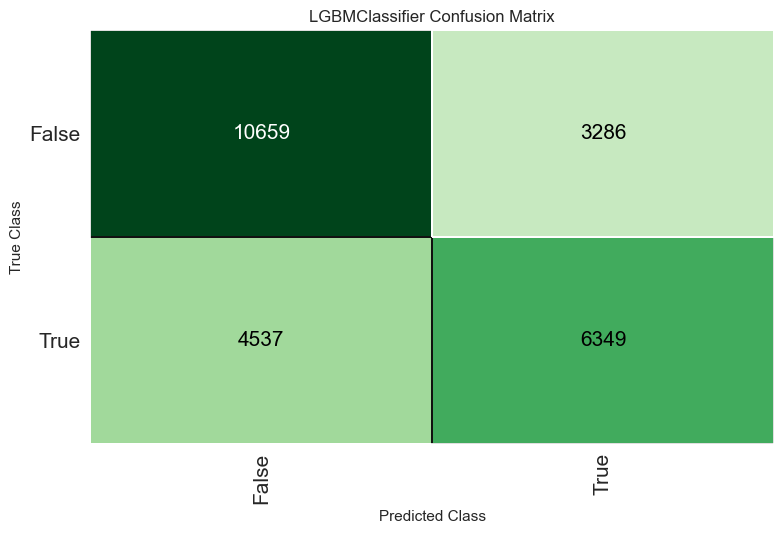

In [76]:
plot_model(lightgbm, plot = 'confusion_matrix')

In [77]:
tuned_lgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6809,0.7397,0.5722,0.6561,0.6113,0.3428,0.3451
1,0.6859,0.7489,0.5787,0.6622,0.6176,0.3531,0.3554
2,0.6828,0.7376,0.5827,0.6554,0.6169,0.3478,0.3496
3,0.6888,0.7497,0.5882,0.6637,0.6237,0.3600,0.3620
4,0.6857,0.7421,0.5780,0.6622,0.6172,0.3527,0.3550
5,0.6918,0.7425,0.5870,0.6692,0.6254,0.3654,0.3677
6,0.6950,0.7533,0.5878,0.6746,0.6282,0.3717,0.3742
7,0.6717,0.7288,0.5646,0.6430,0.6013,0.3242,0.3262
8,0.6820,0.7433,0.5630,0.6614,0.6083,0.3436,0.3467


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [78]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [79]:
predict_model(tuned_lgbm, data=validacao)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.4568,0.7291,0.8852,0.2023,0.3293,0.1114,0.2008


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,idade,tempo_emprego,qt_pessoas_residencia,renda,cat_residencia,mau,prediction_label,prediction_score
600000,F,S,S,2,Assalariado,Superior completo,Casado,38,7.383562,4.0,2969.489990,res_estavel,True,1,0.5900
600001,F,N,S,0,Assalariado,Médio,Casado,55,8.471232,2.0,6278.370117,res_estavel,False,0,0.6767
600002,M,S,S,1,Assalariado,Médio,União,39,8.884932,3.0,14010.179688,res_estavel,False,0,0.7596
600003,F,N,S,1,Assalariado,Médio,União,31,1.794520,3.0,2875.810059,res_instavel,False,1,0.6177
600004,M,S,N,0,Assalariado,Médio,Casado,27,7.019178,2.0,2737.189941,res_estavel,False,1,0.5870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0,Empresário,Superior completo,Casado,48,3.038356,2.0,2109.989990,res_estavel,False,1,0.6599
749996,F,N,S,0,Pensionista,Médio,Solteiro,65,NaN,1.0,1389.390015,res_estavel,False,1,0.7847
749997,M,S,N,2,Assalariado,Médio,Casado,43,10.375342,4.0,649.059998,res_estavel,True,1,0.8514
749998,F,N,S,0,Assalariado,Médio,Viúvo,56,13.780822,1.0,4216.720215,res_estavel,True,0,0.5583


### Salvar o arquivo do modelo treinado

In [80]:
save_model(tuned_lgbm,'Final GBM Model 26Jun2025')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 colsample_bytree=1.0, feature_fraction=0.9,
         

In [81]:
validacao.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,cat_residencia
600000,F,S,S,2,Assalariado,Superior completo,Casado,38,7.383562,4.0,2969.49,True,res_estavel
600001,F,N,S,0,Assalariado,Médio,Casado,55,8.471233,2.0,6278.37,False,res_estavel
600002,M,S,S,1,Assalariado,Médio,União,39,8.884932,3.0,14010.18,False,res_estavel
600003,F,N,S,1,Assalariado,Médio,União,31,1.794521,3.0,2875.81,False,res_instavel
600004,M,S,N,0,Assalariado,Médio,Casado,27,7.019178,2.0,2737.19,False,res_estavel


In [82]:
validacao.reset_index(drop=True).to_feather(r'.\output\validacao.ftr')

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.